<a href="https://colab.research.google.com/github/halcy/tpuddim/blob/main/colab/Danbooru2019Portraits_Inference_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab specific setup
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

!git clone https://github.com/halcy/tpuddim/
%cd tpuddim

Cloning into 'tpuddim'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 148 (delta 72), reused 84 (delta 31), pack-reused 0
Receiving objects: 100% (148/148), 18.96 MiB | 28.30 MiB/s, done.
Resolving deltas: 100% (72/72), done.
/content/tpuddim


In [2]:
# Install dependencies
!pip install -qr requirements.txt

     |████████████████████████████████| 118 kB 5.1 MB/s 
     |████████████████████████████████| 183 kB 51.4 MB/s 
     |████████████████████████████████| 124 kB 64.2 MB/s 
     |████████████████████████████████| 138.2 MB 21 kB/s 
     |████████████████████████████████| 57 kB 3.3 MB/s 


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import ddim.models as models
from ddim.models.model_utils import load_params, get_default_channel_mult
from ddim.diffusion.parameters import linear_beta_schedule, diff_params_from_betas, respace_betas
from ddim.diffusion.inference import denoising_loop, denoising_loop_respaced

import numpy as np
import random

import jax
from jax import numpy as jnp
from jax.experimental.pjit import pjit, PartitionSpec
from jax.experimental.maps import mesh

import jmp

In [4]:
# Config
config = {
    "seed": 1337,
    "mesh_shape": (1, 1, 1), # no sharding on colab, sorry
    "prefix": "with_decay",
    "resume": 8800000,
    "data": {
        "image_size": 128,
        "image_channels": 3,
    },
    
    # UNet config (like OpenAI)
    "model_type": "UNet",
    "model": {
        "model_channels": 128,
        "channel_mult": (1, 1, 2, 3, 4),
        "num_head_channels": 64,
        "use_scale_shift_norm": True,
        "num_res_blocks": 2,
        "attention_resolutions": (32, 16, 8),
    },
    "diffusion": {
        "schedule_steps": 1000,
    }
}

In [5]:
# Jax setup
devices = np.array(jax.devices()[:1]).reshape((1, 1, 1))
precision_policy = jmp.Policy(
    compute_dtype = jnp.bfloat16,
    param_dtype = jnp.bfloat16,
    output_dtype = jnp.float32,
)

In [6]:
# Model download
!gdown https://drive.google.com/u/0/uc?id=1W2Z72PmoeK2p20Efef8YMCKT70BSCw5N -O params_with_decay_8800000.pkl

Downloading...
From: https://drive.google.com/u/0/uc?id=1W2Z72PmoeK2p20Efef8YMCKT70BSCw5N
To: /content/tpuddim/params_with_decay_8800000.pkl
416MB [00:06, 65.9MB/s]


In [7]:
# Set up model
prefix = config["prefix"]
resume = config["resume"]
model_fun = getattr(models, config["model_type"])

config["model"]["out_channels"] = config["data"]["image_channels"]
config["model"]["dtype"] = precision_policy.compute_dtype
config["model"]["dtype_out"] = precision_policy.compute_dtype

model = model_fun(**config["model"])

if config["resume"] is None:
    assert("This is the inference notebook, specify a checkpoint!")
else:
    params = load_params(f"params_{prefix}_{resume}.pkl", devices)
    # TODO: Restore optimizer state?
    
params = precision_policy.cast_to_param(params)

"""
param_count = 0
for param in jax.tree_util.tree_flatten(params)[0]:
    param_count += len(param.flatten())
print(f"param count: {param_count}")
"""

# Initialize diffusion
betas = linear_beta_schedule(config["diffusion"]["schedule_steps"])
diff_params = diff_params_from_betas(betas)
diff_params_respaced = diff_params_from_betas(respace_betas(betas, 25))

/usr/local/lib/python3.7/dist-packages/jax/experimental/pjit.py:160: UserWarning: pjit is an experimental feature and probably has bugs!
  warn("pjit is an experimental feature and probably has bugs!")


In [8]:
# pjit the denoising loop
def denoising_loop_pjit(params, diff_params, images):
    return denoising_loop(model, params, diff_params, images)

denoising_loop_pjit = pjit(denoising_loop_pjit, 
   [
       PartitionSpec(None),
       PartitionSpec(None),
       PartitionSpec("batch", "x", "y")
   ], 
   PartitionSpec("batch", "x", "y"),
   # static_argnums = (0,) # TODO
)

# pjit the denoising loop, respaced edition
def denoising_loop_respaced_pjit(params, diff_params, images):
    return denoising_loop_respaced(model, params, diff_params, images)

denoising_loop_respaced_pjit = pjit(denoising_loop_respaced_pjit, 
   [
       PartitionSpec(None),
       PartitionSpec(None),
       PartitionSpec("batch", "x", "y")
   ], 
   PartitionSpec("batch", "x", "y"),
   # static_argnums = (0,) # TODO
)

/usr/local/lib/python3.7/dist-packages/jax/experimental/pjit.py:160: UserWarning: pjit is an experimental feature and probably has bugs!
  warn("pjit is an experimental feature and probably has bugs!")


In [9]:
# Single image
"""
prng_img = jax.random.PRNGKey(random.randint(0, 2**32))
images_in = jax.random.normal(prng_img, (1, 128, 128, 3))
with mesh(devices, ('batch', 'x', 'y')):
    out = denoising_loop_pjit(params, diff_params, images_in.astype(jnp.float32))
image = np.array(((out[0, :, :, :] + 1.0) * 127.5)).astype(np.uint8)
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()
"""

"\nprng_img = jax.random.PRNGKey(random.randint(0, 2**32))\nimages_in = jax.random.normal(prng_img, (1, 128, 128, 3))\nwith mesh(devices, ('batch', 'x', 'y')):\n    out = denoising_loop_pjit(params, diff_params, images_in.astype(jnp.float32))\nimage = np.array(((out[0, :, :, :] + 1.0) * 127.5)).astype(np.uint8)\nplt.figure(figsize=(8, 8))\nplt.imshow(image)\nplt.show()\n"

In [10]:
"""
# Batch inference
temp = 1.0
    
plt.figure(figsize=(16, 16))
for i in range(0, 25, 5):
    prng_img = jax.random.PRNGKey(random.randint(0, 2**32))
    images_in = jax.random.normal(prng_img, (5, 128, 128, 3)) * temp
    with mesh(devices, ('batch', 'x', 'y')):
        out = denoising_loop_pjit(params, diff_params_respaced, images_in.astype(jnp.float32))
    for j in range(5):
        plt.subplot(5, 5, i + j + 1)
        image = np.array(((out[j, :, :, :] + 1.0) * 127.5)).astype(np.uint8)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.savefig("out2.png")
plt.show()
"""

'\n# Batch inference\ntemp = 1.0\n    \nplt.figure(figsize=(16, 16))\nfor i in range(0, 25, 5):\n    prng_img = jax.random.PRNGKey(random.randint(0, 2**32))\n    images_in = jax.random.normal(prng_img, (5, 128, 128, 3)) * temp\n    with mesh(devices, (\'batch\', \'x\', \'y\')):\n        out = denoising_loop_pjit(params, diff_params_respaced, images_in.astype(jnp.float32))\n    for j in range(5):\n        plt.subplot(5, 5, i + j + 1)\n        image = np.array(((out[j, :, :, :] + 1.0) * 127.5)).astype(np.uint8)\n        plt.imshow(image)\n        plt.xticks([])\n        plt.yticks([])\nplt.tight_layout()\nplt.savefig("out2.png")\nplt.show()\n'

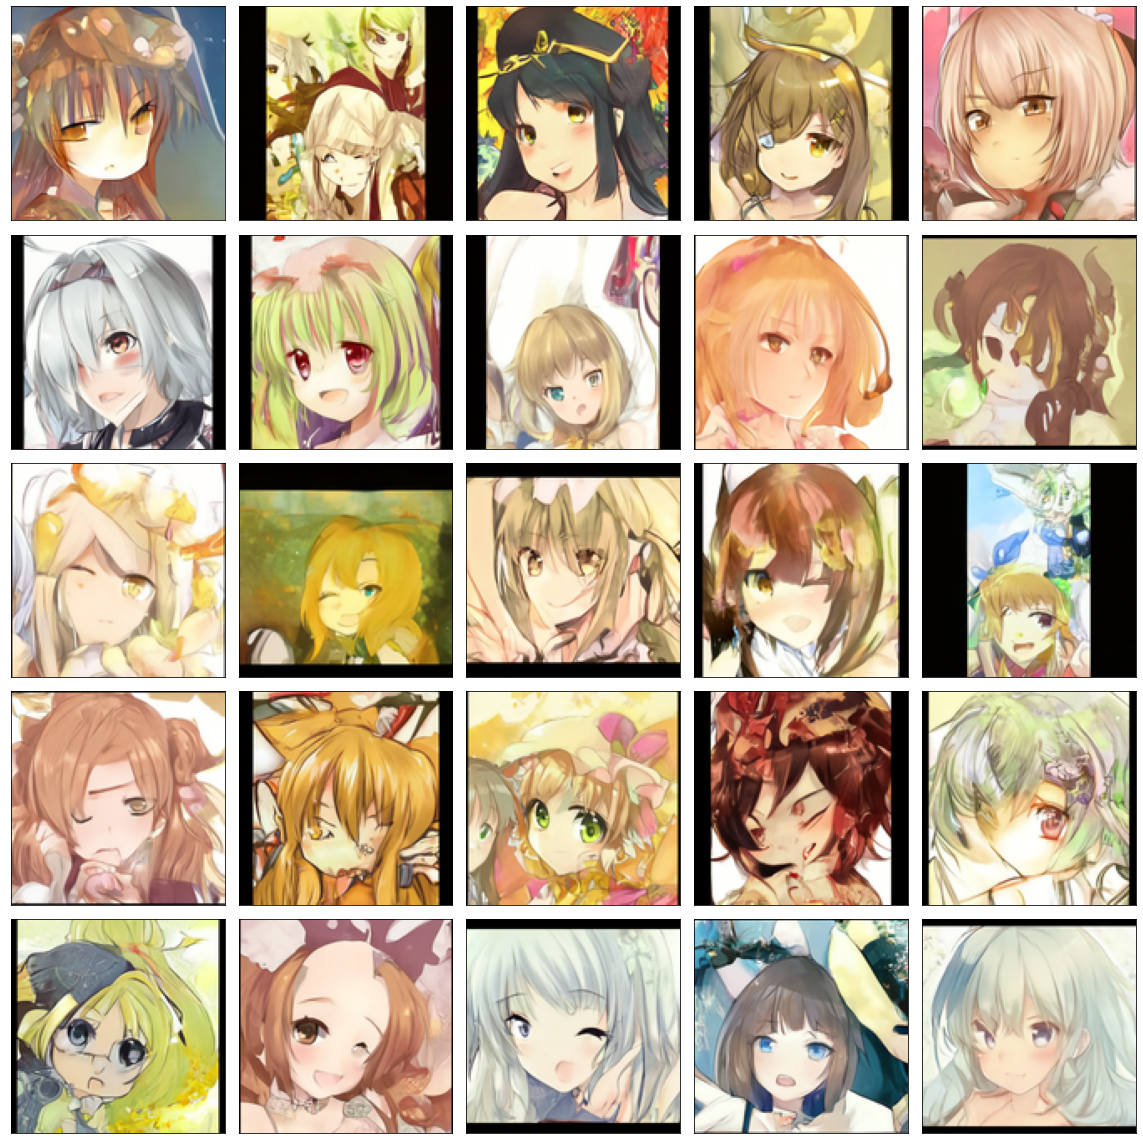

In [11]:
# Batch inference, respaced denoising
temp = 1.0
    
plt.figure(figsize=(16, 16))
for i in range(0, 25, 5):
    prng_img = jax.random.PRNGKey(random.randint(0, 2**32))
    images_in = jax.random.normal(prng_img, (5, 128, 128, 3)) * temp
    with mesh(devices, ('batch', 'x', 'y')):
        out = denoising_loop_respaced_pjit(params, diff_params_respaced, images_in.astype(jnp.float32))
    for j in range(5):
        plt.subplot(5, 5, i + j + 1)
        image = np.array(((out[j, :, :, :] + 1.0) * 127.5)).astype(np.uint8)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.savefig("out2.png")
plt.show()